In [1]:
import os, json
import numpy as np
from argparse import ArgumentParser
from tqdm import tqdm
from collections import defaultdict
import pandas as pdar
from pprint import pprint
import re, string
from google.colab import files
import random

In [30]:
##cloing the git repo
!git clone https://github.com/omar-sharif03/DiscourseEE.git
!cd /content/DiscourseEE && git pull

fatal: destination path 'DiscourseEE' already exists and is not an empty directory.
Already up to date.


In [47]:
def read_json_file(name):
    with open(name, 'r') as f:
        data = json.load(f)
        return data

def save_json(json_data, file_name):
    json_data = json.dumps(json_data)
    print(file_name)
    with open(file_name, "w") as json_file:
          json_file.write(json_data)

##Reading the Data

In [49]:
folder_path = '/content/DiscourseEE/Data'
data_file_name = 'final-data.json'
role_file_name = 'role_definitions.json'

with open(os.path.join(folder_path, data_file_name), "r") as json_file:
    data = json.load(json_file)

with open(os.path.join(folder_path, role_file_name), "r") as json_file:
    events_roles = json.load(json_file)

#Print the JSON data
data[:1]

[{'doc_id': 'doc_0_Joey',
  'id': 'vbjekw',
  'event-label': 'relapse',
  'post': 'How to relapse using Bupe patches?. I recently started using Bupe patches, 10mg of it, and I had bought a morphine prescription prior to that and it’ll be on my hands on 23rd of June. Will I be able to enjoy it? If not, what can I do with the Bupe patch I’m wearing?',
  'comment': 'Yeah he’d have to wait 5 days for the morphine to even have a chance of working. As if he’s wearing a patch it’ll continuously displace the morphine',
  'ground-truth-arguments': {'core-arguments': {'subject/patient': [['individual eager to enjoy relapsing on bupe patches',
      'scattered']],
    'relapse-event': [['relapsing with morphine soon', 'scattered']],
    'resuming-moud-after-relapse': [['possible use of current bupe patch',
      'scattered']],
    'effects': [['null', '']]},
   'type-specific-arguments': {'condition': [['null', '']],
    'trigger': [['morphine prescription', 'explicit']],
    'existing/current-me

## Enumerating the Data

In [50]:
event_types = ['taking-moud', 'relapse', 'tapering']
arg_types = ['core-arguments', 'type-specific-arguments', 'subject-effect-arguments']

for dt in data[:2]: #going over 2 samples of the data file
    all_arguments = dt['ground-truth-arguments']
    print("**************")
    for arg_type in arg_types: #itreating over core, type-specific and subject-effect arguments of each event
        roles = list(all_arguments[arg_type].keys()) #getting the roles of correspoing argument type
        print("---------------")
        print(f"[{dt['event-label']}], [{arg_type}]\n{roles}\n")
        for role in roles:
            values_list = all_arguments[arg_type][role] #annotated argument list
            for value, typ in values_list:
                print(f'{role}: {value} - {typ}') #value is argument value and typ is type(explicit, implicit, scattered)

**************
---------------
[relapse], [core-arguments]
['subject/patient', 'relapse-event', 'resuming-moud-after-relapse', 'effects']

subject/patient: individual eager to enjoy relapsing on bupe patches - scattered
relapse-event: relapsing with morphine soon - scattered
resuming-moud-after-relapse: possible use of current bupe patch - scattered
effects: null - 
---------------
[relapse], [type-specific-arguments]
['condition', 'trigger', 'existing/current-medications', 'relapse-substance', 'relapse-duration', 'relapse-intervention', 'waiting-time']

condition: null - 
trigger: morphine prescription - explicit
existing/current-medications: bupe patch - explicit
relapse-substance: morphine - explicit
relapse-duration: null - 
relapse-intervention: null - 
waiting-time: null - 
---------------
[relapse], [subject-effect-arguments]
['age', 'gender', 'conditions', 'side-effects', 'severity', 'start-time', 'side-effect-duration', 'intervention']

age: null - 
gender: male - implicit
con

## Stattistics

Statistic table 7 regeneration. Check appendix

In [51]:
cnt=0
t_e, t_i, t_s =0, 0, 0
for event in event_types:
    print("**********")
    event_type_ce, event_type_ci, event_type_cs = 0, 0, 0

    for arg_type in arg_types:
        arg_type_ce, arg_type_ci, arg_type_cs = 0, 0, 0
        for dt in data:
            if (dt['event-label']!= event):
                continue
            all_arguments = dt['ground-truth-arguments']
            all_roles = list(all_arguments[arg_type].keys())
            #print(all_roles)
            for role in all_roles:
                values_list = all_arguments[arg_type][role]
                for value, origin in values_list:
                    if(value=='null'): continue
                    cnt+=1
                    if origin == 'explicit':
                        arg_type_ce+=1
                        event_type_ce+=1 #total explicit
                        t_e+=1
                    elif origin == 'implicit':
                        arg_type_ci+=1
                        event_type_ci+=1 #total implicit
                        t_i+=1
                    else:
                        event_type_cs+=1
                        arg_type_cs+=1 #total scattered
                        t_s+=1
        print(event, arg_type)
        print ("#Explicit", arg_type_ce,"#Implicit", arg_type_ci,"#Scattered", arg_type_cs)

print("\n",t_e, t_i, t_s)
print(cnt)

**********
taking-moud core-arguments
#Explicit 86 #Implicit 242 #Scattered 183
taking-moud type-specific-arguments
#Explicit 252 #Implicit 321 #Scattered 39
taking-moud subject-effect-arguments
#Explicit 124 #Implicit 193 #Scattered 52
**********
relapse core-arguments
#Explicit 69 #Implicit 209 #Scattered 139
relapse type-specific-arguments
#Explicit 266 #Implicit 190 #Scattered 45
relapse subject-effect-arguments
#Explicit 114 #Implicit 147 #Scattered 34
**********
tapering core-arguments
#Explicit 53 #Implicit 177 #Scattered 92
tapering type-specific-arguments
#Explicit 151 #Implicit 346 #Scattered 51
tapering subject-effect-arguments
#Explicit 91 #Implicit 145 #Scattered 34

 1206 1970 669
3845


Some part of statistics table 2 of the paper regeneration

In [52]:
def class_statistics(data):
  label_counts = {}
  for dt in data:
      label = dt['event-label']
      if label in label_counts:
          label_counts[label] +=1
      else:
          label_counts[label] = 1
  return label_counts

def read_data():
    folder_path = '/content/DiscourseEE/Data'

    with open(os.path.join(folder_path, "final-train.json"), "r") as json_file:
              train = json.load(json_file)

    with open(os.path.join(folder_path, "final-dev.json"), "r") as json_file:
              dev = json.load(json_file)

    with open(os.path.join(folder_path, "final-test.json"), "r") as json_file:
              test = json.load(json_file)
    return train, dev, test

train, dev, test = read_data()

print("All Data: ", class_statistics(data))
print("Train: ", class_statistics(train))
print("Dev: ", class_statistics(dev))
print("Test: ", class_statistics(test))

All Data:  {'relapse': 118, 'taking-moud': 178, 'tapering': 100}
Train:  {'tapering': 62, 'relapse': 67, 'taking-moud': 117}
Dev:  {'tapering': 14, 'relapse': 16, 'taking-moud': 20}
Test:  {'taking-moud': 41, 'relapse': 35, 'tapering': 24}


In [53]:
def get_event_dict(data):
    event_dict = {}
    for dt in data:
        label = dt['event-label']
        if label in event_dict:
            lst = event_dict[label]
        else:
            lst = [] #initilizing with empty list
        lst.append(dt)
        event_dict[label] = lst
    return event_dict

event_dict = get_event_dict(data)

In [59]:
import nltk
nltk.download('punkt')
event_types = ['taking-moud', 'relapse', 'tapering']
arg_types = ['core-arguments', 'type-specific-arguments', 'subject-effect-arguments']

def is_null_or_empty(string):
    return string is None or string.strip().lower() == 'null' or string.strip() == ''

def count_words(text):
    words = text.split()
    return len(words)

import nltk.data

def count_sentences(text):
    # Initialize the sentence tokenizer
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

    # Tokenize the text into sentences
    sentences = tokenizer.tokenize(text)

    # Return the number of sentences
    return len(sentences)

arg_mention_count = {} ##save the number of arguments
arg_word_count = {} ##save avg. #of words per doc

##for calculating sentences
for event in event_types:
    total_sent, word_count = 0, 0
    for dt in event_dict[event]:
        sent = dt['post']+' '+dt['comment']
        total_sent += count_sentences(sent)
        word_count += count_words(sent)
        #print(count_sentences(sent))
    print(event, "#sent:", total_sent, "#tokens:", word_count,
         "#tokens/doc:", word_count/len(event_dict[event]), "#sent/doc:", total_sent/len(event_dict[event]))

## for calculating statistical counts.
for event in event_types:
    arg_mention_count[event] = {}
    arg_word_count[event] = {}
    for arg_type in arg_types:
        arg_mention_count[event][arg_type] = {}
        arg_word_count[event][arg_type] = {}
        arguments = list(events_roles[event][arg_type].keys())

        for arg in arguments:
            arg_mention_count[event][arg_type][arg] = {}
            arg_word_count[event][arg_type][arg] = {}
            total_count, total_arg_word_cnt = 0, 0 #total count for each argument

            for dt in event_dict[event]:
                dt = dt['ground-truth-arguments']
                g_truth = dt[arg_type][arg] ## list of arguments specific to event, arg_type, argument

                ##doing the argument mention and other counts
                cnt, cnt_words = 0, 0
                for strr, typ in g_truth:
                    if is_null_or_empty(strr):
                        cnt+=1
                    else:
                      cnt_words = count_words(strr)
                #print(arg, dt[arg_type][arg], len(g_truth)-cnt)
                total_count+= len(g_truth)-cnt
                total_arg_word_cnt += cnt_words
            # #print(event, arg_type, arg, total_count,
            #       total_arg_word_cnt, total_arg_word_cnt/(max(total_count, 1)))
            arg_mention_count[event][arg_type][arg] = total_count
            arg_word_count[event][arg_type][arg] = total_arg_word_cnt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


taking-moud #sent: 1453 #tokens: 20080 #tokens/doc: 112.80898876404494 #sent/doc: 8.162921348314606
relapse #sent: 995 #tokens: 13840 #tokens/doc: 117.28813559322033 #sent/doc: 8.432203389830509
tapering #sent: 837 #tokens: 11433 #tokens/doc: 114.33 #sent/doc: 8.37


In [60]:
pprint(arg_mention_count)

{'relapse': {'core-arguments': {'effects': 79,
                                'relapse-event': 116,
                                'resuming-moud-after-relapse': 89,
                                'subject/patient': 133},
             'subject-effect-arguments': {'age': 3,
                                          'conditions': 48,
                                          'gender': 8,
                                          'intervention': 88,
                                          'severity': 37,
                                          'side-effect-duration': 12,
                                          'side-effects': 84,
                                          'start-time': 15},
             'type-specific-arguments': {'condition': 72,
                                         'existing/current-medications': 112,
                                         'relapse-duration': 35,
                                         'relapse-intervention': 63,
                         

In [61]:
for event in events_roles:
    e_count = 0
    for arg_type in arg_types:
        a_type_count = 0
        arguments = list(events_roles[event][arg_type].keys())
        for arg in arguments:
            value = arg_mention_count[event][arg_type][arg]
            a_type_count+= value
        e_count+=a_type_count
        print(event, arg_type, a_type_count)
    print(event, e_count, e_count/len(event_dict[event]))

taking-moud core-arguments 511
taking-moud type-specific-arguments 612
taking-moud subject-effect-arguments 369
taking-moud 1492 8.382022471910112
relapse core-arguments 417
relapse type-specific-arguments 501
relapse subject-effect-arguments 295
relapse 1213 10.279661016949152
tapering core-arguments 322
tapering type-specific-arguments 548
tapering subject-effect-arguments 270
tapering 1140 11.4


In [41]:
for event in events_roles:
    e_count = 0
    for arg_type in arg_types:
        a_type_count = 0
        arguments = list(events_roles[event][arg_type].keys())
        token_count = 0

        for arg in arguments:
            value = arg_mention_count[event][arg_type][arg]
            a_type_count+= value
            token_count += arg_word_count[event][arg_type][arg]
        e_count+=a_type_count
        print(event, arg_type, a_type_count, token_count, token_count/a_type_count)
    print(event, e_count, e_count/len(event_dict[event]))

taking-moud core-arguments 511 2279 4.459882583170255
taking-moud type-specific-arguments 612 1039 1.6977124183006536
taking-moud subject-effect-arguments 369 841 2.279132791327913
taking-moud 1492 8.382022471910112
relapse core-arguments 417 1935 4.640287769784172
relapse type-specific-arguments 501 977 1.9500998003992016
relapse subject-effect-arguments 295 618 2.094915254237288
relapse 1213 10.279661016949152
tapering core-arguments 322 1363 4.232919254658385
tapering type-specific-arguments 548 1057 1.9288321167883211
tapering subject-effect-arguments 270 598 2.214814814814815
tapering 1140 11.4


Pie chart regeneration shown in the appendix

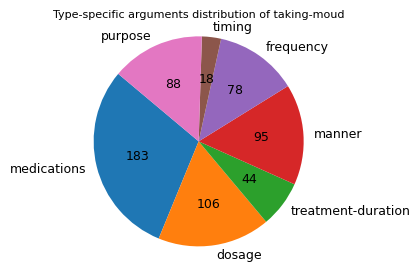

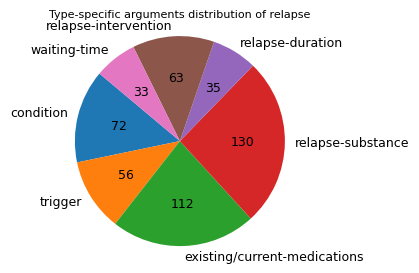

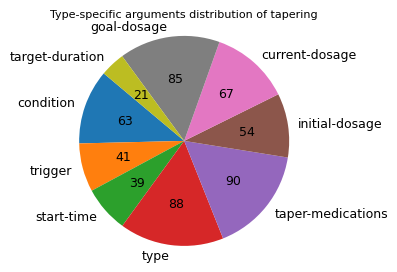

In [43]:
import matplotlib.pyplot as plt

def draw_pie_chart(data, event=None):
    # Get labels and counts from dictionary
    labels = list(data.keys())
    counts = list(data.values())

    # Create pie chart
    plt.figure(figsize=(4, 3))
    plt.pie(counts, labels=labels, autopct=lambda p: '{:.0f}'.format(p * sum(counts) / 100), startangle=140,
            textprops={'fontsize': 9})
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Type-specific arguments distribution of {event}', fontsize =8)
    plt.xticks(fontsize=9)  # X-axis labels font size
    plt.yticks(fontsize=9)

    plt.show()

for event in event_types:
    data = arg_mention_count[event]['type-specific-arguments']
    #pprint(data)
    draw_pie_chart(data, event)

age 4
gender 19
conditions 108
side-effects 296
severity 123
start-time 61
side-effect-duration 51
intervention 272
{'conditions': 108,
 'gender': 19,
 'intervention': 272,
 'severity': 123,
 'side-effect-duration': 51,
 'side-effects': 296,
 'start-time': 61}


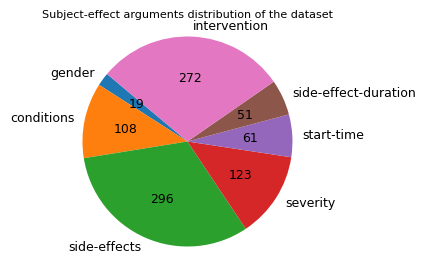

In [44]:
arguments = list(events_roles['taking-moud']['subject-effect-arguments'].keys())

sea_dict = {}
for arg in arguments:
    count = 0
    for event in events_roles:
        count += arg_mention_count[event]['subject-effect-arguments'][arg]
    print(arg, count)
    if(arg=='age'): continue
    sea_dict[arg] = count
pprint(sea_dict)

import matplotlib.pyplot as plt

def draw_pie_chart2(data):
    # Get labels and counts from dictionary
    labels = list(data.keys())
    counts = list(data.values())

    # Create pie chart
    plt.figure(figsize=(4, 3))
    plt.pie(counts, labels=labels, autopct=lambda p: '{:.0f}'.format(p * sum(counts) / 100), startangle=140,
            textprops={'fontsize': 9})
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Subject-effect arguments distribution of the dataset', fontsize =8)
    plt.xticks(fontsize=9)  # X-axis labels font size
    plt.yticks(fontsize=9)

    plt.show()
draw_pie_chart2(sea_dict)
